### Inertia

In [1]:
import numpy as np

cube_length = 0.3       # m
mass = 3                # kg

I = 1/6 * mass * cube_length**2 * np.eye(3)

I

array([[0.045, 0.   , 0.   ],
       [0.   , 0.045, 0.   ],
       [0.   , 0.   , 0.045]])

In [6]:

I_inv = np.linalg.inv(I)

w_exp = I_inv @ [[0],[0],[0.03]] * 0.001

w_exp

array([[0.        ],
       [0.        ],
       [0.00066667]])

### SO(3) Controller

In [78]:
import transforms3d as tf
import numpy as np

# Current Position
roll_cur = np.deg2rad(0.0)
pitch_cur = np.deg2rad(0.0)
yaw_cur = np.deg2rad(0.0)
mat_cur = tf.euler.euler2mat(yaw_cur, pitch_cur, roll_cur)
mat_cur = tf.quaternions.quat2mat([0.0, 0.0, 0.0, 1.0])

# Desiered Position
roll_des = np.deg2rad(10.0)
pitch_des = np.deg2rad(0.0)
yaw_des = np.deg2rad(0.0)

mat_des = tf.euler.euler2mat(yaw_des, pitch_des, roll_des)


R_e = mat_des.T @ mat_cur

e_mat = 0.5 * (R_e - R_e.T)

e_vec = np.array([
    [e_mat[2][1]],
    [e_mat[0][2]],
    [e_mat[1][0]],
])

print(R_e)
print(e_mat)
print(e_vec)

w_cur = np.array([
    [0.0],
    [0.0],
    [0.0],
])

w_des = np.array([
    [0.0],
    [0.0],
    [0.0],
])

e_w = w_cur - (mat_cur.T @ mat_des @ w_des)

print("#############")
print(e_w)

J = np.eye(3)

K_r = 1.0
K_w = 1.0
print("#############")

Jxw = J @ w_cur

print(w_cur)

res = np.cross(w_cur.T, Jxw.T).T

torque = -K_r*e_vec - K_w*e_w + res

print(torque)



[[-0.98480775 -0.17364818  0.        ]
 [ 0.17364818 -0.98480775  0.        ]
 [ 0.          0.          1.        ]]
[[ 0.         -0.17364818  0.        ]
 [ 0.17364818  0.          0.        ]
 [ 0.          0.          0.        ]]
[[0.        ]
 [0.        ]
 [0.17364818]]
#############
[[0.]
 [0.]
 [0.]]
#############
[[0.]
 [0.]
 [0.]]
[[ 0.        ]
 [ 0.        ]
 [-0.17364818]]


# SLERP

In [29]:
import transforms3d as tf
import numpy as np

def slerp(q_init: tf.quaternions, q_des: tf.quaternions, t):

    dot =  qinit @ q_des

    if dot < 0.0:
        q_des = -q_des
        dot = -dot

    # Check if attitude is already very close
    DOT_THRESH = 0.9995
    if dot > DOT_THRESH:
        # linear interpolation
        res = q_init + t * (q_des - q_init)
        return res / np.linalg.norm(res)
    
    thetha_0 = np.arccos(dot)
    sin_theta_0 = np.sin(thetha_0)

    thetha = thetha_0 * t
    sin_theta = np.sin(thetha)

    s0 = np.sin((1.0 - t) * thetha) / sin_theta
    s1 = sin_theta / sin_theta_0

    return s0*q_init + s1*q_des

qinit = tf.euler.euler2quat(0,0,0)
qdes = tf.euler.euler2quat(40,0,0)

timespan = 5
contr_loop_per = 0.5

slerp_poses_q = []

for t in np.linspace(0+contr_loop_per, timespan, int(timespan/contr_loop_per)):
    slp = slerp(qinit, qdes, t)
    print(slp.T)
    slerp_poses_q.append(slp)


[0.76459238 0.54402111 0.         0.        ]
[0.40808206 0.91294525 0.         0.        ]
[-0.32724498  0.98803162  0.          0.        ]
[-0.66693806  0.74511316  0.          0.        ]
[3.63038855 0.26237485 0.         0.        ]
[ 1.7685771  -0.30481062  0.          0.        ]
[-1.11927    -0.77389068 -0.         -0.        ]
[ 0.50699526 -0.99388865  0.          0.        ]
[-1.14560552 -0.89399666 -0.         -0.        ]
[-1.90678747 -0.50636564 -0.         -0.        ]


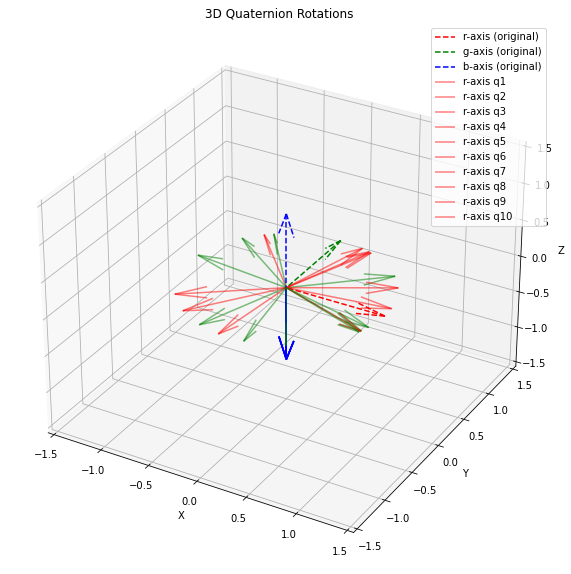

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.transform import Rotation as R

# Example: list of quaternions (w, x, y, z)
quaternions = slerp_poses_q

# Create a 3D plot
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
# Draw original axes (before rotation)
origin = np.zeros(3)
axis_length = 1.0
colors = ['r', 'g', 'b']  # x, y, z

# for i, color in enumerate(colors):
    # axis = np.eye(3)[i] * axis_length
    # ax.quiver(*origin, *axis, color=color, linestyle='dashed', label=f'{color}-axis (original)')

# Apply each quaternion to the basis vectors and plot the rotated frames
for idx, quat in enumerate(quaternions):
    #r = R.from_quat(quat[1:] + [quat[0]])  # convert (w, x, y, z) to (x, y, z, w)
    r = R.from_quat(quat)
    rotated_axes = r.apply(np.eye(3)) * axis_length
    for i, color in enumerate(colors):
        ax.quiver(*origin, *rotated_axes[i], color=color, alpha=0.5, label=f'{color}-axis q{idx+1}' if i == 0 else None)

ax.set_xlim([-1.5, 1.5])
ax.set_ylim([-1.5, 1.5])
ax.set_zlim([-1.5, 1.5])
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("3D Quaternion Rotations")
ax.legend()

plt.show()
